In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
%reload_ext autoreload

from functions import *

from trading import Asset
from trading.variables.errors import ERRORS
from trading.grid_search.brute_force import BruteGridSearch

from time import time
from copy import deepcopy
from datetime import date
import matplotlib.pyplot as plt
import plotly.express as xp

In [3]:
def normalize(df, cols):

    for col in cols:
        df[col] = ( df[col] - df[col].min() ) / ( df[col].max() - df[col].min() )

    return df

In [1]:
def features(asset, clf = True):
    ori_cols = asset.df.drop(columns = ["volume"]).columns

    for i in [20, 40, 60, 80]:
        asset.df[ f"ema_{i}"] = asset.ema(i)
        asset.df[ f"roc_{i}" ] = asset.roc(i)

        for j in range(2, 12, 3):
            asset.df[ f"ema_{i}_slope_{j}" ] = asset.df[ f"ema_{i}" ].pct_change( j )
        
        for c in ["close", "high", "volume"]:
            asset.df["std{}_{}".format(c, i)] = asset.df[c].rolling(i).std()

    for i in [7, 14, 21]:
        asset.df[ f"rsi_{i}"] = asset.rsi_smoth(i, 2)
        
        for j in range(2,7, 2):
            asset.df[ f"rsi_{i}_slope_{j}" ] = asset.df[ f"rsi_{i}" ].pct_change( j )
    
    for i in [2,3,4,5,6]:
        asset.df[f"momentum_{i}"] = asset.momentum(i)
        asset.df[f"momentum_ema_{i}"] = asset.momentum(i, target = "ema_20")
        asset.df[f"momentum_rsi_{i}"] = asset.momentum(i, target = "rsi_7")

    asset.df["hl"] = asset.df["high"] - asset.df["low"]
    asset.df["ho"] = asset.df["high"] - asset.df["open"]
    asset.df["lo"] = asset.df["low"] - asset.df["open"]
    asset.df["cl"] = asset.df["close"] - asset.df["low"]
    asset.df["ch"] = asset.df["close"] - asset.df["high"]

    asset.df["buy_wf"] = asset.william_fractals(2, shift=True)
    for i in [2,3,4]:
        for j in [2,3,4]:
            asset.df[f"oneside_gaussian_filter_slope_{i}_{j}"] = asset.oneside_gaussian_filter_slope(i,j)

    asset.df["obv"] = asset.obv()

    for i in [20, 40, 60]:
        s, r = asset.support_resistance(i)
        asset.df[ f"support_{i}" ] = ( s / asset.df["close"] ) - 1
        asset.df[ f"resistance_{i}" ] = ( r / asset.df["close"] ) - 1

    # Normalization
    n_cols = list( set(asset.df.columns) - set(ori_cols) )
    
    asset.df = normalize(asset.df, cols = n_cols)

    asset.df["engulfing"] = asset.engulfing()
    asset.df["william_buy"] = asset.william_fractals(2, order = "buy").apply(lambda x : 1 if x == True else 0).rolling(5).sum()
    asset.df["william_sell"] = asset.william_fractals(2, order = "sell").apply(lambda x : 1 if x == True else 0).rolling(5).sum()

    if clf:
        asset.df["target"] = asset.df["close"].pct_change().shift(-1).apply(lambda x: 1 if x > 0 else 0)
    else:
        asset.df["target"] = asset.df["close"].pct_change().shift(-1)

    asset.df.drop(columns = ori_cols, inplace = True)

    return asset

In [5]:
class Prediction():

    def __init__(
            self,
            model,
            asset = None,
            conf = {},
            num_assets = 0,
            
            data_manipulation = None,
            error = None,
            multiple_errors = False,

            train_size = None,
            cv = False,

            **kwargs,

        ):
        """  
            Input:

                train_size (int, float): If lower than '1', then it is set considered as a percentaje,
                    but if '1' or bigger, it is considered as the quantity of instances to take for the train set.

                cv (bool): Cross-Validation
                    If true, set cvf (Cross-Validation folds) variable to the desired folds.
                
                kwargs:
                    If desired to change model params of a already set model, you can set 'model_params'
                    with a dictionary of the desired params to set.

            regr: 
                Output: y_true, y_pred ( list/pd.Series tupple ) 
                    o   error (float)
        """

        self.model = model

        assert asset or conf, "Asset or conf must be filled."

        # Autogenerate assets
        self.auto = False

        if asset:
            self.asset = asset
        else:
            self.auto = True
            self.conf = conf
            self.num_assets = num_assets

        self.data_manipulation = data_manipulation
        self.error = error
        self.multiple_errors = multiple_errors

        # self.instrumentos = random.choices( list( self.instrumentos ), k = num_assets )

        self.exec_time = 0
        self.cache = {
            "data_manipulation" : [],
            "regr" : [],
            "error" : []
        }
    
    @property
    def model(self):
        return self.__model
    
    @model.setter
    def model(self, value):
        if value is None:
            raise ValueError("model must be input")

        if not (callable(value.fit) and callable(value.predict) ):
            raise ValueError( f"Model obj must have declared a 'fit' and 'predict' function." )

        self.__model = value

    @property
    def data_manipulation(self):
        return self.__data_manipulation
    
    @data_manipulation.setter
    def data_manipulation(self, value):
        if value is None:
            self.__data_manipulation = value
        # elif isinstance(value, str): # When datamanipulation (features) functions exists
        #     self.__data_manipulation = ERRORS[ value ]
        elif callable(value):
            self.__data_manipulation = value
        else:
            raise ValueError(f"data_manipulation must be a known function or a function, but {type(value)} was given.")

    @property
    def error(self):
        return self.__error
    
    @error.setter
    def error(self, value):
        if value is None:
            self.__error = value
        elif isinstance(value, str):
            self.__error = ERRORS[ value ]
        elif callable(value):
            self.__error = value
        else:
            raise ValueError(f"error must be a known function or a function, but {type(value)} was given.")

    def single_run(self, asset):
        asset = self.data_manipulation(asset)

    def run(self, verbose = False, timing = True):
        
        if self.multiple_errors:
            assert ( self.error is None or isinstance(self.error, list) ), "Se ha indicado de multiples errores, pero error no es una lista, o "

        if timing: start_time = time.time()

        self.results = []

        for i in self.instrumentos:
            if verbose: print(i)

            aux = [i]
            inst = Asset( 
                i, 
                self.inicio, 
                self.fin, 
                frecuencia = self.frecuencia, 
                broker = self.broker, 
                fiat = self.fiat,
                desde_api=False
            )

            if inst.df is None or len(inst.df) < 5: continue

            data_man = self.data_manipulation( inst )
            if isinstance(data_man, Asset):
                inst = data_man
            else:
                inst, auxx = data_man
                self.cache["data_manipulation"].append( [i, auxx] )
            

            regr = self.regr( inst )

            if self.error is None:
                if isinstance(regr, float) or isinstance(regr, int):
                    error = regr
                else:
                    error, auxx = regr
                    self.cache["regr"].append([i, auxx])

                if self.multiple_errors:    aux += error
                else:                       aux.append(error)
            
            else:
                if len(regr) > 2:       
                    y_true, y_pred, auxx = regr
                    self.cache["regr"].append([i, auxx])
                else:
                    y_true, y_pred = regr
                
                if y_true is None and y_pred is None: continue

                if self.multiple_errors:    aux += [ j( y_true, y_pred ) for j in self.error ]
                else:                       aux.append( self.error( y_true, y_pred ) )
            
            print(aux)

            self.results.append( aux )
        
        self.results = pd.DataFrame( self.results )

        if timing: self.exec_time = time.time() - start_time

        if verbose: print("Done!")

In [6]:
asset = new("LTC", start = date(2020,1,1))

# Classifiers

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from trading.variables.params_grid import RF_C_GRID

In [ ]:
casset = features( deepcopy(asset), clf = True )

In [ ]:
bt = BruteGridSearch( casset.df, regr=RandomForestClassifier(), parameters=RF_C_GRID , error_ascending= False)
bt.test()
p = bt.predict(one = False)

# Regressions

In [56]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from trading.variables.params_grid import RF_R_GRID, DT_R_GRID

In [57]:
rasset = features( deepcopy(asset), clf = False )

In [58]:
GRID = {'n_estimators': [ 100, 200, 500, 1000],
 'criterion': ['squared_error', 'absolute_errors'],
 }

In [59]:
bti = BruteGridSearch( rasset.df, regr=RandomForestRegressor(), parameters=GRID , error_ascending= True)
bti.test()
p = bti.predict(one = False)

Text(0, 0.5, 'Predict')

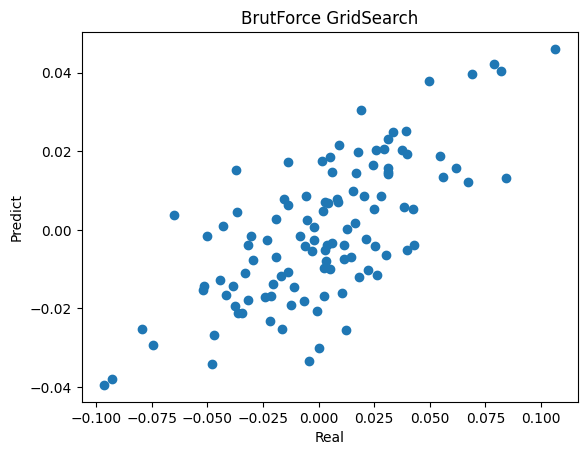

In [60]:
plt.scatter(y = p,  x = bti.testset["target"].values)
plt.title("BrutForce GridSearch")
plt.xlabel("Real")
plt.ylabel("Predict")

In [18]:
from sklearn.model_selection import GridSearchCV

In [21]:
gscv = GridSearchCV(RandomForestRegressor(), GRID, cv = 5)

In [22]:
gscv.fit( bt.trainset.drop(columns = ["target"]) , bt.trainset["target"] )

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'criterion': ['squared_error', 'absolute_error'],
                         'n_estimators': [10, 20, 50, 100, 200, 500]})

In [55]:
gscv.best_params_

{'criterion': 'squared_error', 'n_estimators': 500}

In [23]:
pgs = gscv.predict( bt.testset.drop(columns = ["target"]) )

Text(0, 0.5, 'Predict')

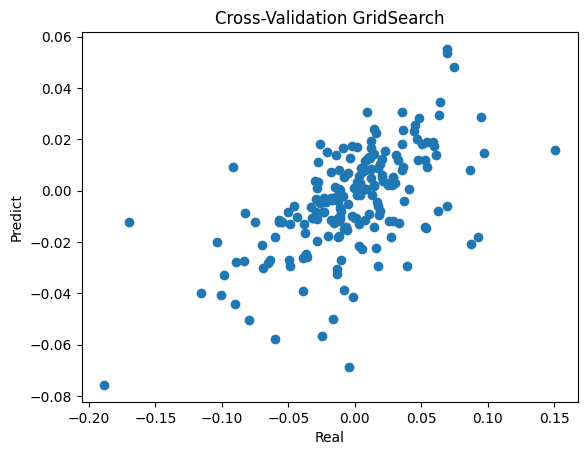

In [25]:
plt.scatter(y = pgs,  x = bt.testset["target"].values)
plt.title("Cross-Validation GridSearch")
plt.xlabel("Real")
plt.ylabel("Predict")

Text(0, 0.5, 'Predict')

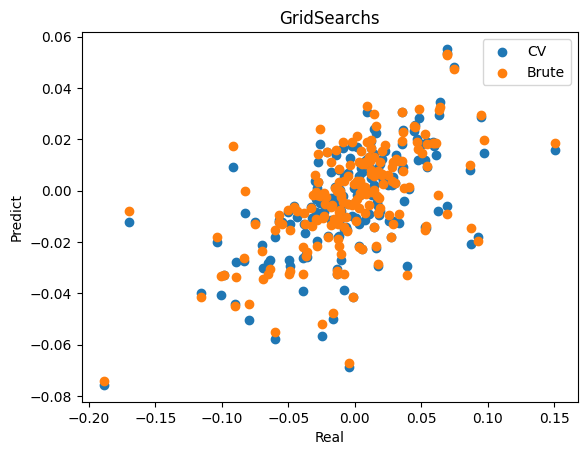

In [33]:
plt.scatter(y = pgs,  x = bt.testset["target"].values, label = "CV")
plt.scatter(y = p,  x = bt.testset["target"].values, label = "Brute")
plt.legend()
plt.title("GridSearchs")
plt.xlabel("Real")
plt.ylabel("Predict")

## Use of Panel Data

In [35]:
from trading.func_brokers import get_assets
import numpy as np

In [51]:
GRID =  {'n_estimators': [ 100, 200, 500],
 'criterion': ['squared_error', 'absolute_error']}

{'n_estimators': [10, 20, 50, 100, 200, 500],
 'criterion': ['squared_error', 'absolute_error']}

In [39]:
binance = np.random.choice( list(get_assets()["binance"].keys()) , 10 )

In [40]:
df = pd.DataFrame()

for symbol in binance:
    asset = new(symbol, start = date(2020,1,1))
    rasset = features( deepcopy(asset), clf = False )

    df = pd.concat([ df, rasset.df ], axis = 0)

df.shape

In [41]:
df.shape

(8360, 75)

In [43]:
bt = BruteGridSearch( df, regr=RandomForestRegressor(), parameters=GRID , error_ascending= True)
bt.test()
ppd = bt.predict(one = False)

Text(0, 0.5, 'Predict')

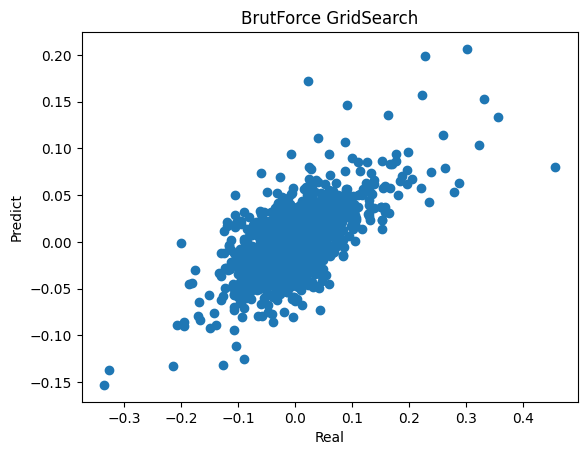

In [45]:
plt.scatter(y = ppd,  x = bt.testset["target"].values)
plt.title("BrutForce GridSearch")
plt.xlabel("Real")
plt.ylabel("Predict")

In [48]:
import pickle


In [54]:
bt.regr.__dict__

{'base_estimator': DecisionTreeRegressor(),
 'n_estimators': 500,
 'estimator_params': ('criterion',
  'max_depth',
  'min_samples_split',
  'min_samples_leaf',
  'min_weight_fraction_leaf',
  'max_features',
  'max_leaf_nodes',
  'min_impurity_decrease',
  'random_state',
  'ccp_alpha'),
 'bootstrap': True,
 'oob_score': False,
 'n_jobs': None,
 'random_state': None,
 'verbose': 0,
 'warm_start': False,
 'class_weight': None,
 'max_samples': None,
 'criterion': 'absolute_error',
 'max_depth': None,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.0,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'ccp_alpha': 0.0,
 'feature_names_in_': array(['volume', 'ema_20', 'roc_20', 'ema_20_slope_2', 'ema_20_slope_5',
        'ema_20_slope_8', 'ema_20_slope_11', 'stdclose_20', 'stdhigh_20',
        'stdvolume_20', 'ema_40', 'roc_40', 'ema_40_slope_2',
        'ema_40_slope_5', 'ema_40_slope_8', 'ema_40_slope_11',
        'stdclose_40'

In [49]:
pickle.dump(bt.regr, open("Models/RF_10Assets_BruteFroce", 'wb'))